### Prepare data

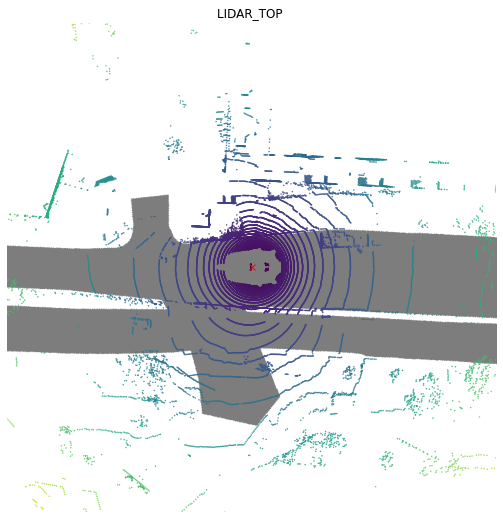

(4, 34688)


array([[-3.1243734e+00, -3.2906363e+00, -3.4704101e+00, ...,
        -1.4129141e+01, -1.4120683e+01, -1.4113669e+01],
       [-4.3415368e-01, -4.3220678e-01, -4.3068862e-01, ...,
         4.9357712e-03,  9.8654358e-03,  1.4782516e-02],
       [-1.8671920e+00, -1.8631892e+00, -1.8595628e+00, ...,
         1.9857219e+00,  2.3199446e+00,  2.6591547e+00],
       [ 4.0000000e+00,  1.0000000e+00,  2.0000000e+00, ...,
         8.0000000e+01,  7.5000000e+01,  4.0000000e+01]], dtype=float32)

In [1]:
%matplotlib inline
import os
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.nuscenes import NuScenes

VERSION = 'v1.0-mini'
DATAROOT = '/Users/kaitoY/data/nuScenes/mini'

nusc = NuScenes(version=VERSION, dataroot=DATAROOT, verbose=False)
my_scene = nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
sample_data_token = my_sample['data']['LIDAR_TOP']
my_sample_data = nusc.get('sample_data', sample_data_token)
# Visualize
nusc.render_sample_data(sample_data_token,
                        with_anns=False,
                        show_lidarseg=False)
# Raw data
pc = LidarPointCloud.from_file(os.path.join(DATAROOT, my_sample_data['filename']))
print(pc.points.shape)
pc.points

### Visualization

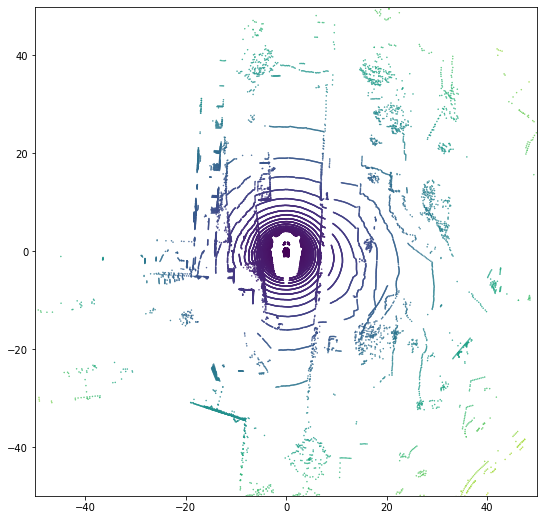

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from nuscenes.utils.geometry_utils import view_points
%matplotlib inline

# Settings
axes_limit = 50.0 # Axes limit measured in meters.
_, ax = plt.subplots(1, 1, figsize=(9, 9))
ax.set_xlim(-axes_limit, axes_limit)
ax.set_ylim(-axes_limit, axes_limit)
# Treat sensor as reference coordinate system
viewpoint = np.eye(4)
# Map 3d points to 2d
points = view_points(pc.points[:3, :], viewpoint, normalize=False)
dists = np.sqrt(np.sum(pc.points[:2, :] ** 2, axis=0))
colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
point_scale = 0.2
scatter = ax.scatter(points[0, :], points[1, :], c=colors, s=point_scale)

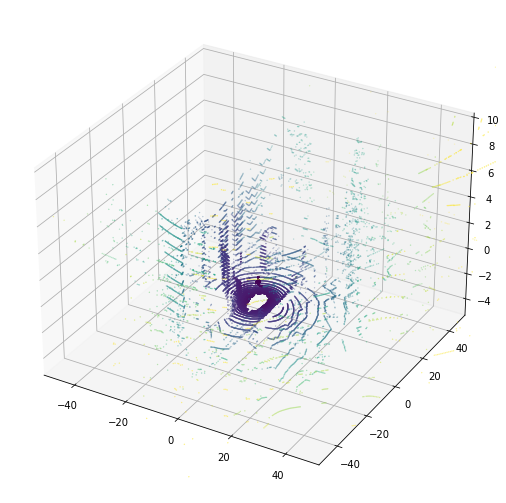

In [3]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.figure.set_size_inches(9, 9)
ax.set_xlim(-axes_limit, axes_limit)
ax.set_ylim(-axes_limit, axes_limit)
ax.set_zlim(-5, 10)

ax.scatter(pc.points[0, :], pc.points[1, :], pc.points[2, :], c = colors, s=0.1)
plt.show()

In [4]:
#Define a function that takes as input an array of points, and a voxel size expressed in meters. It returns the sampled point cloud
def grid_subsampling(points, voxel_size):
    # The number of voxel along 3 (X, Y, Z) dimensions
    nb_vox=np.ceil((np.max(points, axis=0) - np.min(points, axis=0))/voxel_size)
    # Place points into voxel grid, multiple points inside same grid will share index key.
    non_empty_voxel_keys, inverse, nb_pts_per_voxel= np.unique(
        ((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
    idx_pts_vox_sorted=np.argsort(inverse)
    voxel_grid={}
    grid_barycenter,grid_candidate_center=[],[]
    last_seen=0

    for idx,vox in enumerate(non_empty_voxel_keys):
        # Fetch all points for the current index key
        voxel_grid[tuple(vox)]=points[idx_pts_vox_sorted[last_seen:last_seen+nb_pts_per_voxel[idx]]]
        # Calculate mean
        grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))
        # Closest point to the meaned center inside a grid
        grid_candidate_center.append(
            voxel_grid[tuple(vox)][
                np.linalg.norm(voxel_grid[tuple(vox)]-np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()
            ])
        last_seen+=nb_pts_per_voxel[idx]

    return grid_candidate_center

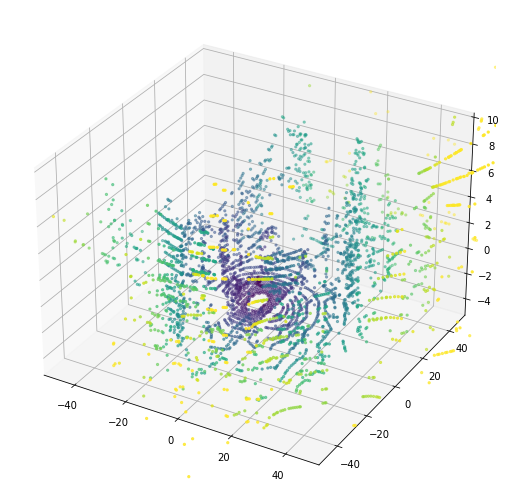

In [5]:
# Set voxel size to 1 meter
voxelized = grid_subsampling(pc.points[:3, :].T , 1)
voxelized = np.array(voxelized)
# Visualization
dists = np.sqrt(np.sum(voxelized.T ** 2, axis=0))
colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
ax = plt.axes(projection='3d')
ax.figure.set_size_inches(9, 9)
ax.set_xlim(-axes_limit, axes_limit)
ax.set_ylim(-axes_limit, axes_limit)
ax.set_zlim(-5, 10)
ax.scatter(voxelized[:, 0], voxelized[:, 1], voxelized[:, 2], c = colors, s=5)
plt.show()
